# Initialization

## Imports

In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid")

In [7]:
import sys
sys.path.append('/home/tevo/Applications/optunity')
import optunity
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from spikeHelper.loadSpike import Rat

## Functions

In [68]:
def splitTrials(dataWithMultipleIdxPerTrial,n_splits):
    kf = KFold(n_splits=n_splits)
    trials = np.unique(dataWithMultipleIdxPerTrial)
    folds = {'train':{},'test':{}}
    for i,item in enumerate(kf.split(trials)):
        trainTrials, testTrials = trials[item[0]], trials[item[1]]
        trainBoolIdx = np.array([i in trainTrials for i in dataWithMultipleIdxPerTrial])
        testBoolIdx = np.array([i in testTrials for i in dataWithMultipleIdxPerTrial])
        
        assert len(testBoolIdx) == len(trainBoolIdx)
        assert not any(testBoolIdx == trainBoolIdx)
        
        folds['train'][i] = trainBoolIdx
        folds['test'][i] = testBoolIdx
    return folds

In [144]:
def optimalPars(X, y, trial, cv=5):
    def myFolds(X, y, trial, cv):
        folds = splitTrials(trial,cv)
        scores = []
        
        def svm_rbf_tuned_auroc(x_train, y_train, x_test, y_test, C, logGamma):
            model = SVC(C=C, gamma=10 ** logGamma).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            auc = cohen_kappa_score(y_test, y_pred, weights='quadratic')
            return auc
    
        def wrapper(C, logGamma):
            for cvi in range(cv):
                Xtrain, ytrain = X[folds['train'][cvi],:], y[folds['train'][cvi]]
                Xtest, ytest = X[folds['test'][cvi],:], y[folds['test'][cvi]]
                scores.append(svm_rbf_tuned_auroc(Xtrain, ytrain, Xtest, ytest, C, logGamma))
            return np.mean(scores) - np.std(scores)
        return wrapper

    cvOptimal=pd.DataFrame(columns = ['logGamma','C'])
    optimal_rbf_pars, _, _ = optunity.maximize(myFolds(X,y,trial,cv), num_evals=150, C=[0, 60], logGamma=[-7,0])
    cvOptimal = pd.concat((cvOptimal,pd.DataFrame(optimal_rbf_pars,index=[1]) ) )
    return cvOptimal

# Find optimal hyperparameters

## Generate

In [145]:
allRatsOptimal = pd.DataFrame(columns = ['logGamma','C','Rat'])
for rat in [7,8,9,10]:
    data = Rat(rat)
    data.selecTrials({'minDuration':1500,'maxDuration':4000})
    data.selecTimes(tmin=200,tmax=1200)
    data.describe()
    oneOptimal = optimalPars(data.X,data.y,data.trial,cv=10)
    oneOptimal['Rat']=rat
    allRatsOptimal = pd.concat((allRatsOptimal,oneOptimal))
allRatsOptimal

Label: Rat 7
Bin size: 100
Sigma: 100

Using 624 trials, according to following restrictions:
minDuration: 1500
maxDuration: 4000

Using 10 time bins:
From 200 to 300ms
From 300 to 400ms
From 400 to 500ms
.
.
.
From 1000 to 1100ms
From 1100 to 1200ms
Label: Rat 8
Bin size: 100
Sigma: 100

Using 423 trials, according to following restrictions:
minDuration: 1500
maxDuration: 4000

Using 10 time bins:
From 200 to 300ms
From 300 to 400ms
From 400 to 500ms
.
.
.
From 1000 to 1100ms
From 1100 to 1200ms
Label: Rat 9
Bin size: 100
Sigma: 100

Using 394 trials, according to following restrictions:
minDuration: 1500
maxDuration: 4000

Using 10 time bins:
From 200 to 300ms
From 300 to 400ms
From 400 to 500ms
.
.
.
From 1000 to 1100ms
From 1100 to 1200ms
Label: Rat 10
Bin size: 100
Sigma: 100

Using 944 trials, according to following restrictions:
minDuration: 1500
maxDuration: 4000

Using 10 time bins:
From 200 to 300ms
From 300 to 400ms
From 400 to 500ms
.
.
.
From 1000 to 1100ms
From 1100 to 12

,C,Rat,logGamma
1,48.164062,7,-3.623047
1,1.933594,8,-5.010742
1,46.054688,9,-6.658203
1,2.916566,10,-4.357622


## Look and save

In [147]:
allRatsOptimal

,C,Rat,logGamma
1,48.164062,7,-3.623047
1,1.933594,8,-5.010742
1,46.054688,9,-6.658203
1,2.916566,10,-4.357622


In [193]:
import time
dayLabel = time.asctime(time.localtime())[:11]

In [202]:
import pickle
pickle.dump(allRatsOptimal, open('Data/optimalParameters_'+dayLabel+'.pickle','wb'))

In [203]:
ls Data

50ms_r10_1000to1500.pickle            r10_bin50_sigma100.pickle2
50ms_r10_1300msPlus1s.pickle          r10_bin50_sigma20.pickle
50ms_r10_2000to2500.pickle            r10_bin50_sigma50.pickle
50ms_r10_3000to3500.pickle            r10_filtered_epoch_gabi.pickle
50ms_r7_1000to1500.pickle             r10_sigma100norm.pickle
50ms_r7_1300msPlus1s.pickle           r7_bin100_sigma100.pickle
50ms_r7_2000to2500.pickle             r7_bin100_sigma50.pickle
50ms_r7_3000to3500.pickle             r7_bin50_sigma100.pickle
50ms_r8_1000msPlus.pickle             r7_bin50_sigma100.pickle2
50ms_r8_1000to1500.pickle             r7_bin50_sigma20.pickle
50ms_r8_1300msPlus1s.pickle           r7_bin50_sigma50.pickle
50ms_r8_2000to2500.pickle             r7_filtered_epoch_fr1_isi5.pickle
50ms_r8_3000to3500.pickle             r7_filtered_epoch_gabi.pickle
50ms_r9_1000msPlus.pickle             r7_sigma100norm.pickle
50ms_r9_1000to1500.pickle             r8_bin100_sigma100.pickle
50ms_r9_1300msPlus1s.pickle        

# Test performance in beginning and end

In [5]:
from spikeHelper.dataOrganization import loadBestParams
from spikeHelper.similarities import temporalGeneralization
ntrials = 100
results = {'end':{},'beg':{},'crossTestBeg':{},'crossTestEnd':{}}
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    
    beg = trialToXyT(data[:,:,:ntrials])
    end = trialToXyT(data[:,:,-ntrials:])
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    #results['beg'][rat] = temporalGeneralization(getX(beg), beg['y'], beg['trial'], clf,returnCubic=True)
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    #results['end'][rat] = temporalGeneralization(getX(end), end['y'], end['trial'], clf,returnCubic=True)
    
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    results['crossTestEnd'][rat], _ = crossGeneralization(beg,end,rat)
    results['crossTestBeg'][rat], _ = crossGeneralization(end,beg,rat)

Calculating for rat 7 using 715 trials and 29 neurons
Calculating for rat 8 using 503 trials and 37 neurons
Calculating for rat 9 using 448 trials and 29 neurons
Calculating for rat 10 using 1110 trials and 65 neurons


In [15]:
ras = pd.DataFrame(results).iloc[:,1:3]
ras.applymap(performanceFromConfusion)

,crossTestBeg,crossTestEnd
7,0.055864,-0.000830
8,0.501801,0.354769
9,0.247980,0.172623
10,0.162449,0.123000


In [7]:
from sklearn.metrics import confusion_matrix
def crossGeneralization(epochsTrain,epochsTest,rat):
    '''Trains on all of the first input, and tests in each of the second'''
    Xtrain, ytrain = epochsTrain.X, epochsTrain.y
    Xtest, ytest = epochsTest.X, epochsTest.y
    ytrial = epochsTest.trial


    parameters = loadBestParams(rat)
    clf = SVC(C=parameters['C'], gamma=10**parameters['logGamma'], decision_function_shape='ovr')
    clf.fit(Xtrain,ytrain)

    n_classes = max(len(np.unique(ytest)),len(np.unique(ytrain)) )
        
    trials = np.unique(epochsTest.trial)
    confusionPerTrial = np.full((n_classes,n_classes,trials.shape[0]), 0)
    for i,testTrial in enumerate(np.unique(ytrial)):
        ypred = clf.predict(Xtest[ytrial==testTrial, :])

        confusionPerTrial[:,:,i] = confusion_matrix(ytest[ytrial==testTrial], ypred,labels=np.arange(n_classes))

    ntrain, ntest = len(np.unique(ytrain)), len(np.unique(ytest))
    tempGen = np.full((ntrain,ntest),np.nan)
    for real_y in np.unique(ytest):
        tempGen[:,real_y-min(ytest)] = clf.decision_function(Xtest[ytest==real_y]).mean(axis=0)

    return confusionPerTrial,tempGen

In [5]:
from spikeHelper.loadSpike import Rat

In [8]:
ntrials = 100
results = pd.DataFrame(columns = ['when','type','rat','value'])
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    rb = Rat(rat,binSize=50)
    rb.selecTrials({'minDuration':1300,'maxDuration':4000,'ntrials':50})
    rb.selecTimes(200,1000)
    
    re = Rat(rat,binSize=50)
    re.selecTrials({'minDuration':1300,'maxDuration':4000,'trialMin':'best','ntrials':50})
    re.selecTimes(200,1000)
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(rb.X, rb.y, rb.trial, clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0) 
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(re.X, re.y, re.trial, clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0)
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    aux, _ = crossGeneralization(rb,re,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)
    aux, _ = crossGeneralization(re,rb,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)

Calculating for rat 7 using 715 trials and 29 neurons
Calculating for rat 8 using 503 trials and 37 neurons
Calculating for rat 9 using 448 trials and 29 neurons
Calculating for rat 10 using 1110 trials and 65 neurons


In [38]:
#pickle.dump(results,open('2808cubicConfusion_bin50_sigma100','wb'))
idx = np.logical_and(results['when']=='beg',results['type'] =='cross')
results.loc[idx,'when']='temp'
idx = np.logical_and(results['when']=='end',results['type'] =='cross')
results.loc[idx,'when']='beg'
idx = np.logical_and(results['when']=='temp',results['type'] =='cross')
results.loc[idx,'when']='end'


In [8]:
results = pickle.load(open('2808cubicConfusion_bin50_sigma100','rb'))

In [38]:
res = results.applymap(lambda x: performanceFromConfusion(x[2:18,2:18,:]))
res

,beg,end
7,0.187280,-0.061479
8,0.355999,0.343480
9,0.415610,0.265619
10,0.248193,0.129619


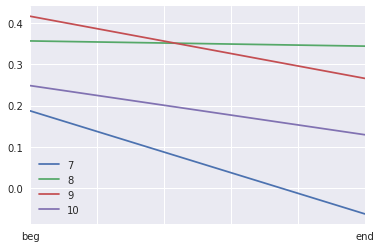

In [40]:
res.transpose().plot()

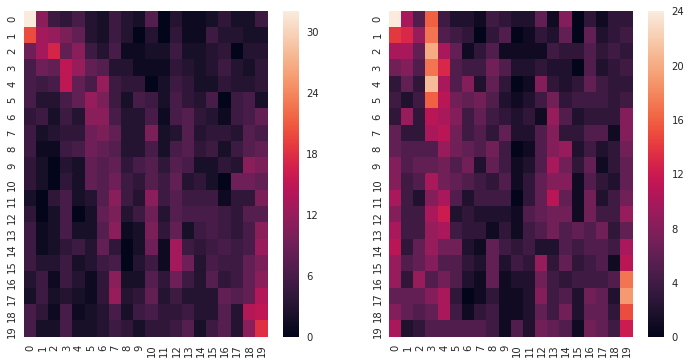

In [32]:
rat = 10
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(res['beg'][rat])
plt.subplot(1,2,2)
sns.heatmap(res['end'][rat])

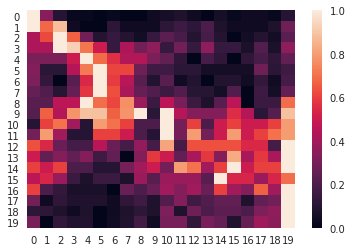

In [20]:
from spikeHelper.dataOrganization import normRows
sns.heatmap(normRows(res['beg'][9]))

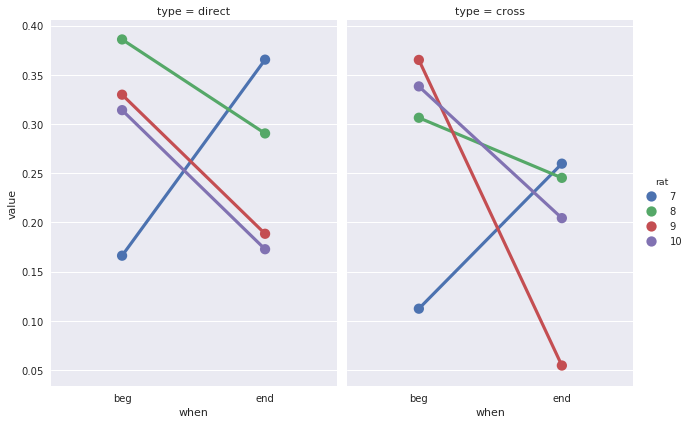

In [9]:
g = sns.factorplot( x="when", y="value", hue="rat", col="type", data=results,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

In [ ]:
ntrials = 100
results = pd.DataFrame(columns = ['when','type','rat','value'])
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    
    beg = trialToXyT(data[:,:,:ntrials])
    end = trialToXyT(data[:,:,-ntrials:])
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(beg), beg['y'], beg['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0) 
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(end), end['y'], end['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0)
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    aux, _ = crossGeneralization(beg,end,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)
    aux, _ = crossGeneralization(end,beg,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)

# Evolução do desempenho dos classificadores treinados nas últimas tentativas

---